In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
#Get the ISO-Codes
iso = pd.read_csv("ISO/ISO.csv")

In [2]:
# --- NEW: Load DataFrames from CSV ---
print("\nLoading W_ij DataFrames from CSV files...")
W_ij_dataframes = {}
csv_filenames = ['W_1_ij.csv', 'W_2_ij.csv', 'W_3_ij.csv']
for filename in csv_filenames:
    try:
        df_reloaded = pd.read_csv(filename)
        reloaded_df_name = os.path.splitext(filename)[0] # Get original df_name from filename
        W_ij_dataframes[reloaded_df_name] = df_reloaded
        print(f"Loaded {filename}")
    except Exception as e:
        print(f"Error loading {filename}: {e}")


Loading W_ij DataFrames from CSV files...
Loaded W_1_ij.csv
Loaded W_2_ij.csv
Loaded W_3_ij.csv


In [3]:
# Define the desired start and end periods for filtering
start_period = 1989 
end_period = 2020  

print(f"\nFiltering DataFrames for periods between {start_period} and {end_period}...")
# Iterate through the dictionary and filter dataframes in-place
for df_name, df_content in W_ij_dataframes.items():
    if not df_content.empty and 'period' in df_content.columns:
        # Apply the period filter directly to the DataFrame in the dictionary
        original_rows = len(df_content)
        W_ij_dataframes[df_name] = df_content[(df_content['period'] >= start_period) & (df_content['period'] <= end_period)]
        print(f"Filtered {df_name}. Original rows: {original_rows}, Filtered rows: {len(W_ij_dataframes[df_name])}")
    else:
        print(f"Skipping filtering for {df_name}: DataFrame is empty or 'period' column is missing.")



Filtering DataFrames for periods between 1989 and 2020...
Filtered W_1_ij. Original rows: 31911, Filtered rows: 27179
Filtered W_2_ij. Original rows: 12271, Filtered rows: 10586
Filtered W_3_ij. Original rows: 94337, Filtered rows: 78649



Saving plot to normalized_inconsistencies_plot.png with 300 DPI...
Plot saved successfully!


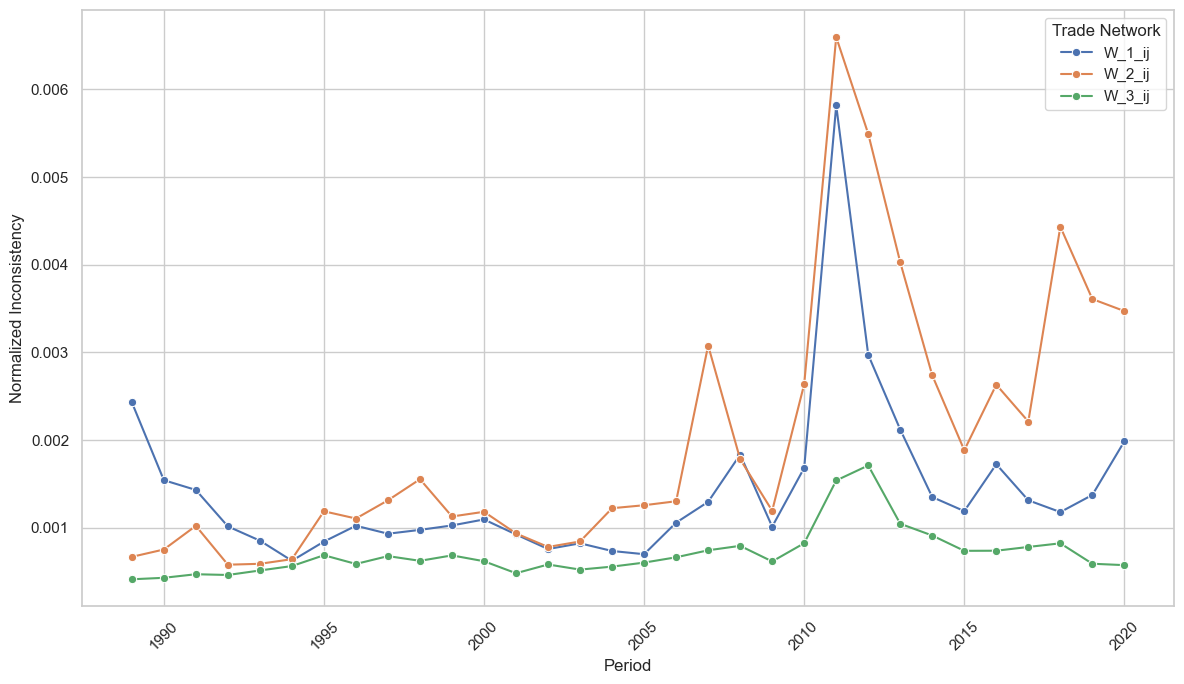

In [4]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 7))


# Loop through each W_ij DataFrame to plot its normalized inconsistencies
for cap, dataframe in W_ij_dataframes.items():
    if not dataframe.empty and 'inconsistency' in dataframe.columns: # Ensure dataframe is not empty and has the column
        # Create a distinct copy to avoid SettingWithCopyWarning
        dataframe_copy = dataframe.copy()

        # A new MinMaxScaler is initialized for each dataframe, ensuring independent scaling.
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataframe_copy['normalized_inconsistency'] = scaler.fit_transform(
            dataframe_copy[['inconsistency']] # Use dataframe_copy here
        )

        # Aggregate normalized inconsistency per period for plotting
        # Using mean to get a single value per period, if multiple entries exist
        inconsistency_per_period = dataframe_copy.groupby('period')['normalized_inconsistency'].mean().reset_index() # Corrected variable here

        # Plot the normalized inconsistencies
        sns.lineplot(
            data=inconsistency_per_period,
            x='period',
            y='normalized_inconsistency',
            marker='o',
            label=f'{cap}' 
            )
    else:
        print(f"Skipping {cap}: DataFrame is empty or 'inconsistency' column is missing after filtering.") # Corrected variable here


plt.xlabel('Period')
plt.ylabel('Normalized Inconsistency') # Updated label
plt.legend(title='Trade Network')
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels/titles from overlapping

output_filename = 'normalized_inconsistencies_plot.png'
output_dpi = 300 # Dots per inch (higher DPI means better quality)

print(f"\nSaving plot to {output_filename} with {output_dpi} DPI...")
try:
    plt.savefig(output_filename, dpi=output_dpi, bbox_inches='tight')
    print("Plot saved successfully!")
except Exception as e:
    print(f"Error saving plot: {e}")


plt.show()


In [5]:
hhi_results = []

for df_name, df in W_ij_dataframes.items():
    # Calculate HHI per period
    df['share'] = df.groupby('period')['W_ij'].transform(lambda x: x / x.sum())
    df['share_squared'] = df['share']**2
    hhi_per_period = df.groupby('period')['share_squared'].sum().reset_index()
    hhi_per_period['DataFrame'] = df_name
    hhi_results.append(hhi_per_period)

# Combine all HHI results into a single DataFrame
final_hhi_df = pd.concat(hhi_results, ignore_index=True)

print(final_hhi_df)

    period  share_squared DataFrame
0     1989       0.139920    W_1_ij
1     1990       0.086145    W_1_ij
2     1991       0.066687    W_1_ij
3     1992       0.054715    W_1_ij
4     1993       0.055320    W_1_ij
..     ...            ...       ...
91    2016       0.023318    W_3_ij
92    2017       0.022537    W_3_ij
93    2018       0.023725    W_3_ij
94    2019       0.025825    W_3_ij
95    2020       0.027396    W_3_ij

[96 rows x 3 columns]


C:\Users\nilsl\AppData\Local\Temp\ipykernel_30632\3218180943.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['share'] = df.groupby('period')['W_ij'].transform(lambda x: x / x.sum())
C:\Users\nilsl\AppData\Local\Temp\ipykernel_30632\3218180943.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['share_squared'] = df['share']**2


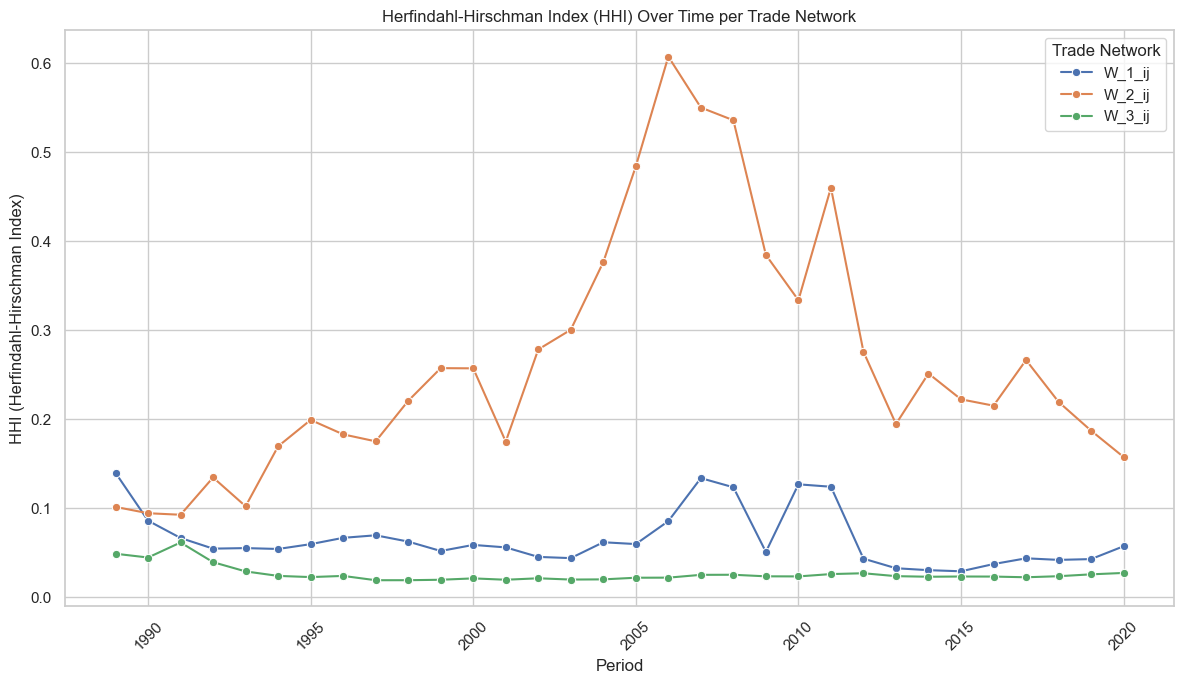

In [6]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 7))

# Use 'hue' to plot separate lines for each 'DataFrame' category
sns.lineplot(
    data=final_hhi_df,
    x='period',
    y='share_squared',
    hue='DataFrame',  # This creates separate lines for each unique value in 'DataFrame'
    marker='o'
)

plt.xlabel('Period')
plt.ylabel('HHI (Herfindahl-Hirschman Index)') # Corrected label
plt.title('Herfindahl-Hirschman Index (HHI) Over Time per Trade Network') # Added a title
plt.legend(title='Trade Network')
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels/titles from overlapping 


plt.show()